# < 네이버 영화리뷰 감성분석 도전하기 >

**< 목차 >**

□ Step1 데이터 준비와 확인   
□ Step2 데이터로더 구성   
□ Step3 모델구성을 위한 데이터 분석 및 가공   
□ Step4 모델1: RNN(LSTM) 훈련 및 시각화   
□ Step5 모델2: 1-D CNN 훈련 및 시각화   
□ Step6 모델3: GlobalMaxPooling1D 훈련 및 시각화   
□ Step7 학습된 Embedding 레이어 분석   
□ Step8 한국어 Word2Vec 임베딩 활용하여 성능개선   
□ Step9 Dropout을 추가하여 RNN 모델 성능 더 개선하기   
□ 정리 및 회고

### ■ Step1 데이터 준비와 확인

**1-1 필요한 라이브러리 import**

In [7]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

**1-2 데이터 로드 및 확인**

In [8]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### ■ Step2 데이터로더 구성

**2-1 data_loder 함수 만들기**

In [9]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    # X_train, y_train, X_test, y_test, word_to_index 리턴
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

**2-2 data_loder 함수로 데이터 불러오기**

In [10]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [11]:
print(X_train[0])
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


**2-3 word_to_index 확인**

In [12]:
# word_to_index 확인
print(len(word_to_index))
print(word_to_index)

9997
{'': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 104, '냐': 105, '재미없': 106, '쓰레기': 107, '

In [13]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

**2-4 index_to_word 구성**

In [14]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[0])

<PAD>


**2-5 인코딩, 디코딩 함수 만들기**

In [15]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

**2-6 디코딩 확인**

In [16]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### ■ Step3 모델구성을 위한 데이터 분석 및 가공

**3-1 데이터셋 내 문장 길이 분포**

In [17]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


**3-2 적절한 최대 문장 길이 지정**

In [18]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


**3-3 패딩 추가 : keras.preprocessing.sequence.pad_sequences을 활용**

In [19]:
x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='pre', # 혹은 'post'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='pre', # 혹은 'post'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [20]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

**3-4 validation set 구성**

In [21]:
# validation set 20000건 분리
x_val = x_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 훈련 데이터로 사용
partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### ■ Step4 모델1: RNN(LSTM) 훈련 및 시각화

**4-1 모델 구성**

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


**4-2 모델 학습**

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 6s 13ms/step - loss: 0.6325 - accuracy: 0.6630 - val_loss: 0.3794 - val_accuracy: 0.8395
Epoch 2/10
247/247 [==============================] - 3s 10ms/step - loss: 0.3517 - accuracy: 0.8538 - val_loss: 0.3458 - val_accuracy: 0.8512
Epoch 3/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3146 - accuracy: 0.8700 - val_loss: 0.3540 - val_accuracy: 0.8438
Epoch 4/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3005 - accuracy: 0.8756 - val_loss: 0.3419 - val_accuracy: 0.8529
Epoch 5/10
247/247 [==============================] - 2s 10ms/step - loss: 0.2854 - accuracy: 0.8835 - val_loss: 0.3467 - val_accuracy: 0.8522
Epoch 6/10
247/247 [==============================] - 2s 10ms/step - loss: 0.2735 - accuracy: 0.8885 - val_loss: 0.3511 - val_accuracy: 0.8495
Epoch 7/10
247/247 [==============================] - 2s 10ms/step - loss: 0.2689 - accuracy: 0.8916 - val_loss: 0.3567 - val_accuracy: 0.8491

**4-3 모델 평가**

In [24]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.3819 - accuracy: 0.8437
[0.3819013833999634, 0.8437455296516418]


**4-4 Accuracy, Loss 그래프 시각화**

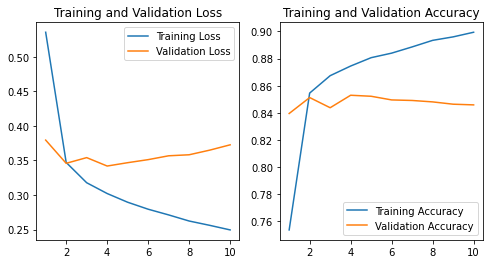

In [25]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

### ■ Step5 모델2: 1-D CNN 훈련 및 시각화

**5-1 모델 구성**

In [26]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

**5-2 모델 학습**

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 11s 27ms/step - loss: 0.6080 - accuracy: 0.6395 - val_loss: 0.3566 - val_accuracy: 0.8437
Epoch 2/10
247/247 [==============================] - 2s 8ms/step - loss: 0.3260 - accuracy: 0.8631 - val_loss: 0.3448 - val_accuracy: 0.8494
Epoch 3/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2864 - accuracy: 0.8814 - val_loss: 0.3399 - val_accuracy: 0.8543
Epoch 4/10
247/247 [==============================] - 2s 8ms/step - loss: 0.2600 - accuracy: 0.8962 - val_loss: 0.3460 - val_accuracy: 0.8539
Epoch 5/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2277 - accuracy: 0.9121 - val_loss: 0.3623 - val_accuracy: 0.8510
Epoch 6/10
247/247 [==============================] - 2s 7ms/step - loss: 0.1930 - accuracy: 0.9296 - val_loss: 0.3869 - val_accuracy: 0.8455
Epoch 7/10
247/247 [==============================] - 2s 8ms/step - loss: 0.1591 - accuracy: 0.9451 - val_loss: 0.4200 - val_accuracy: 0.8433
Epoc

**5-3 모델 평가**

In [28]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.5586 - accuracy: 0.8297
[0.5585951209068298, 0.829749584197998]


**5-4 Accuracy, Loss 그래프 시각화**

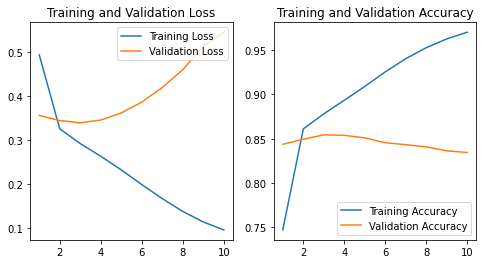

In [29]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

### ■ Step6 모델3: GlobalMaxPooling1D 훈련 및 시각화

**6-1 모델 구성**

In [30]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


**6-2 모델 학습**

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 6ms/step - loss: 0.6520 - accuracy: 0.6689 - val_loss: 0.4195 - val_accuracy: 0.8224
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3857 - accuracy: 0.8376 - val_loss: 0.3598 - val_accuracy: 0.8404
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3273 - accuracy: 0.8620 - val_loss: 0.3499 - val_accuracy: 0.8467
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2954 - accuracy: 0.8774 - val_loss: 0.3498 - val_accuracy: 0.8472
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2774 - accuracy: 0.8876 - val_loss: 0.3540 - val_accuracy: 0.8482
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.8963 - val_loss: 0.3604 - val_accuracy: 0.8484
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2427 - accuracy: 0.9034 - val_loss: 0.3684 - val_accuracy: 0.8469
Epoch 

**6-3 모델 평가**

In [32]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.4114 - accuracy: 0.8376
[0.411356657743454, 0.8375816345214844]


**6-4 Accuracy, Loss 그래프 시각화**

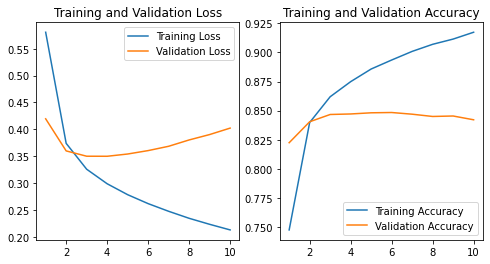

In [33]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

### ■ Step7 학습된 Embedding 레이어 분석

**7-1 필요한 패키지 설치**

In [33]:
pip list | grep gensim

gensim                        4.0.1
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


**7-2 embedding_layer weights 확인**

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


**7-3 word2vec 파일로 저장**

In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

**7-4 임베딩 파라미터를 읽어 word vector로 활용**

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.13071527, -0.00292702, -0.06364875, -0.07333343,  0.04976857,
       -0.1028634 , -0.09522544,  0.21599829,  0.05149811,  0.03472248,
       -0.14530532, -0.10201851, -0.169219  , -0.16975752, -0.10662449,
        0.23177001], dtype=float32)

**7-5 유사한 단어와 유사도 확인**

In [37]:
word_vectors.similar_by_word("사랑")

[('아이콘', 0.8473002910614014),
 ('마법사', 0.8248868584632874),
 ('처', 0.8198076486587524),
 ('라이언', 0.8195427656173706),
 ('고급', 0.8184086084365845),
 ('하루카', 0.8161834478378296),
 ('배출', 0.807274341583252),
 ('아들', 0.7995555400848389),
 ('알린', 0.79854816198349),
 ('목사', 0.7945653200149536)]

- '사랑'이라는 단어로 유사도를 확인해 봤는데, 연광성이 없는 단어들이 출력되었다.

### ■ Step8 한국어 Word2Vec 임베딩 활용하여 성능개선

**8-1 gensim 버전 낮추기**

In [38]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 24.2 MB 25.8 MB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [38]:
import gensim
gensim.__version__

'3.8.3'

**8-2 한국어 Word2Vec 가져오기 : [링크](https://github.com/Kyubyong/wordvectors)**

In [45]:
import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)
vector = ko_model['사랑']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


(200,)

**8-3 유사한 단어와 유사도 확인**

In [40]:
ko_model.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [44]:
ko_model.wv.most_similar("자유")

[('평화', 0.5491458177566528),
 ('위태', 0.5251628160476685),
 ('평등', 0.518025279045105),
 ('풍요', 0.5137975215911865),
 ('기본권', 0.5062314867973328),
 ('조화', 0.5023700594902039),
 ('자유권', 0.5014395713806152),
 ('권리', 0.4880094528198242),
 ('평등권', 0.4815441370010376),
 ('생존권', 0.48100847005844116)]

- '사랑', '자유'라는 단어로 유사도를 확인했을 때, 연광성이 있는 단어들이 출력되었다!

**8-4 embedding_matrix 생성**

In [43]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수는 ko_model의 vector 차원수 200으로!
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 ko_model 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


**8-5 한국어 Word2Vec(ko_model)로 다시 모델 학습-평가: 'RNN(LSTM)' 모델**

In [46]:
from tensorflow.keras.initializers import Constant

In [50]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8)) 
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 9s 29ms/step - loss: 0.6064 - accuracy: 0.6468 - val_loss: 0.4028 - val_accuracy: 0.8232
Epoch 2/5
247/247 [==============================] - 7s 27ms/step - loss: 0.3734 - accuracy: 0.8395 - val_loss: 0.3586 - val_accuracy: 0.8439
Epoch 3/5
247/247 [==============================] - 7s 27ms/step - loss: 0.3224 - accuracy: 0.8657 - val_loss: 0.3495 - val_accuracy: 0.8480
Epoch 4/5
247/247 [==============================] - 7s 27ms/step - loss: 0.2960 - accuracy: 0.8789 - val_loss: 0.3492 - val_accuracy: 0.8504
Epoch 5/5
247/247 [==============================] - 7s 27ms/step - loss: 0.2808 - accuracy: 0.8872 - val_loss: 0.3480 - val_accuracy: 0.8505


In [51]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.3562 - accuracy: 0.8482
[0.3562213182449341, 0.8482413291931152]


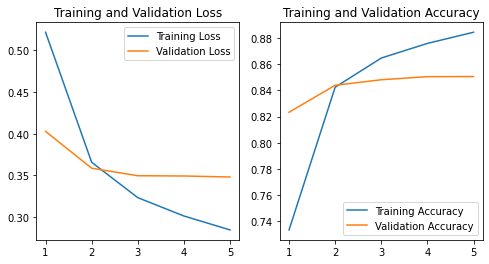

In [52]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

**8-6 한국어 Word2Vec(ko_model)로 다시 모델 학습-평가: '1D-CNN' 모델**

In [53]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 13s 40ms/step - loss: 0.5998 - accuracy: 0.6562 - val_loss: 0.4255 - val_accuracy: 0.8055
Epoch 2/5
247/247 [==============================] - 7s 28ms/step - loss: 0.3902 - accuracy: 0.8268 - val_loss: 0.3674 - val_accuracy: 0.8363
Epoch 3/5
247/247 [==============================] - 7s 28ms/step - loss: 0.3243 - accuracy: 0.8629 - val_loss: 0.3522 - val_accuracy: 0.8440
Epoch 4/5
247/247 [==============================] - 7s 28ms/step - loss: 0.2867 - accuracy: 0.8814 - val_loss: 0.3497 - val_accuracy: 0.8483
Epoch 5/5
247/247 [==============================] - 7s 28ms/step - loss: 0.2585 - accuracy: 0.8956 - val_loss: 0.3554 - val_accuracy: 0.8482


In [54]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.3671 - accuracy: 0.8464
[0.36714839935302734, 0.8463698029518127]


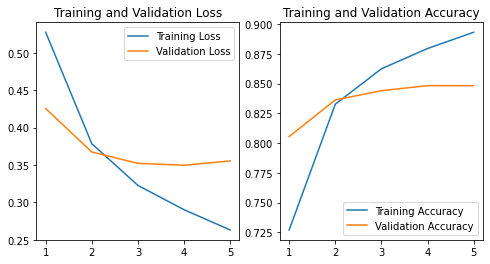

In [55]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

**8-7 한국어 Word2Vec(ko_model)로 다시 모델 학습-평가: 'GlobalMaxPooling1D' 모델**

In [62]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 6s 23ms/step - loss: 0.7552 - accuracy: 0.5539 - val_loss: 0.5863 - val_accuracy: 0.6931
Epoch 2/5
247/247 [==============================] - 6s 23ms/step - loss: 0.5688 - accuracy: 0.7062 - val_loss: 0.5314 - val_accuracy: 0.7364
Epoch 3/5
247/247 [==============================] - 6s 23ms/step - loss: 0.5073 - accuracy: 0.7520 - val_loss: 0.4859 - val_accuracy: 0.7648
Epoch 4/5
247/247 [==============================] - 6s 23ms/step - loss: 0.4631 - accuracy: 0.7820 - val_loss: 0.4636 - val_accuracy: 0.7814
Epoch 5/5
247/247 [==============================] - 6s 23ms/step - loss: 0.4261 - accuracy: 0.8062 - val_loss: 0.4402 - val_accuracy: 0.7964


In [63]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4463 - accuracy: 0.7909
[0.44632095098495483, 0.7908741235733032]


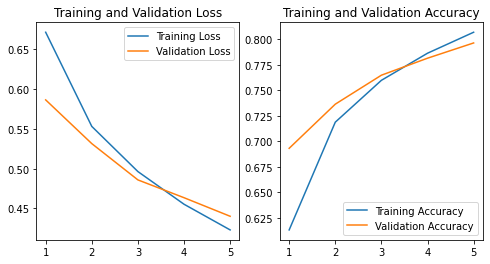

In [64]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

- 기존 모델 학습시 epochs을 10으로 했는데, 대부분 epochs 2 이후로는 traing과 validatin의 간격이 넓어졌기에, 한국어 word2vec에서는 epchs을 5로 감소시켰다.

- RNN, 1-CNN 모델은 약간의 성능 향상이 있었으나, Maxpooling 모델은 오히려 성능이 감소하였다.

- 하지만 세 모델 모두 test set에서 0.85 이상의 정확도가 나오지는 않았다.

- 가장 성능이 좋은 RNN 모델의 성능을 더 개선시켜 보겠다.

### ■ Step9 Dropout을 추가하여 RNN 모델 성능 더 개선하기

In [66]:
from keras.layers import Dropout

In [81]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              
epochs=10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
493/493 [==============================] - 13s 23ms/step - loss: 0.6593 - accuracy: 0.5864 - val_loss: 0.4128 - val_accuracy: 0.8243
Epoch 2/10
493/493 [==============================] - 11s 22ms/step - loss: 0.4710 - accuracy: 0.8040 - val_loss: 0.3643 - val_accuracy: 0.8414
Epoch 3/10
493/493 [==============================] - 11s 22ms/step - loss: 0.4109 - accuracy: 0.8384 - val_loss: 0.3513 - val_accuracy: 0.8457
Epoch 4/10
493/493 [==============================] - 11s 22ms/step - loss: 0.3861 - accuracy: 0.8498 - val_loss: 0.3429 - val_accuracy: 0.8510
Epoch 5/10
493/493 [==============================] - 11s 22ms/step - loss: 0.3687 - accuracy: 0.8562 - val_loss: 0.3418 - val_accuracy: 0.8516
Epoch 6/10
493/493 [==============================] - 11s 22ms/step - loss: 0.3565 - accuracy: 0.8621 - val_loss: 0.3508 - val_accuracy: 0.8534
Epoch 7/10
493/493 [==============================] - 11s 22ms/step - loss: 0.3424 - accuracy: 0.8666 - val_loss: 0.3538 - val_accuracy:

In [82]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.3844 - accuracy: 0.8518
[0.3843557834625244, 0.8518013954162598]


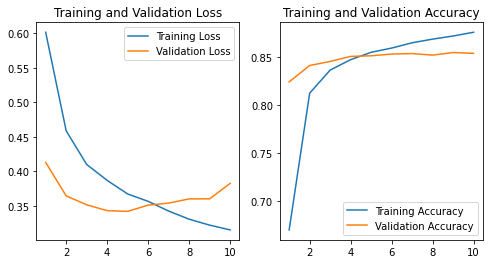

In [83]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

### ■ 정리 및 회고

**1. 0.85 이상의 성능이 나오기까지..**

한국어 word2vec로 모델을 학습하여 평가했을 때, 3가지 모델 다 test set에서 0.85 이상의 성능이 나오지 않았다. 그래서 그 중 가장 성능이 좋은 RNN에 모델에 dropout을 적용해 보았다. 하지만 너무나 안타깝게도 0.849에서 더이상 성능이 올라가지 않았다. epochs을 5에서 10으로 바꿔보아도 마찬가지였다. 그러다가 지난 EX4 작사가 노드에서 batch_size를 줄여서 성능을 높여보려던게 생각나서, batch_size를 512에서 256으로 변경하였다. 결국 0.851의 결과를 얻게 되었다! (더 줄이면 더 올라가려나..?)

|모델|기본(epochs=10)|한국어 Word2Vec(epochs=5)|Dropout|
|---|---|---|---|
|RNN|0.8437|0.8482|0.8518|
|1D-CNN|0.8297|0.8464|미실시|
|Maxpooling|0.8376|0.7909|미실시|

**2. gensim의 버전 다운그레이드 문제**

한국어 word2vec(ko.bin)를 사용하려고 하는데 자꾸 에러가 나서 알아보니 gensim의 버전을 다운그레이드 해야했다. 그래서 `pip install --upgrade gensim==3.8.3` 명령어를 통해 버전을 낮추었다.

**3. word_vector_dim 값 문제**

gensim 버전 다운그레이드 후에도 한국어 word2vec(ko.bin)를 사용하려고 하면 shape 에러가 발생했는데 word_vector_dim 값의 문제였다. 한국어 word2vec를 embedding_matrix로 만들어 사용하게 되면 한국어 word2vec의 vector값으로 word_vector_dim을 설정해주어야했다. 그래서 word_vector_dim을 임의로 줄 수없었고 200으로 하여 에러를 해결하였다. 추후에 embedding_matrix를 사용하지 않고 word_vector_dim 값을 변경해가며 모델을 학습시켜봐야겠다.

**4. NLP 노드에 관해서..**

NLP노드가 나올 때마다 느끼는 것이지만, 흐름 자체를 이해하는데 더 어려움이 있다. 개념이 생소한 것인지, 용어가 아직 익숙하지 않아서인지 잘 모르겠다.. 그래도 자연어처리에 대해 많이 공부하고 싶다!